# Social Network: The Treasure And Shoe Archive from Drehem

The Treasure and Shoe archive from Drehem (ancient Puzriš-Dagan) is a relatively small archive (< 300 documents) of administrative texts that date to the 21st century BCE and deal with valuable objects (made of metals and valuable stones), leather objects (shoes, boots, etc.) and weapons. The archive was studied in detail by Paola Paoletti in her book *Der König und sein Kreis* (2012). The present notebook essentially takes the texts edited and studied by Paoletti, assigning roles to personal names in each text and creating edges between actors in the documents. By identifying nodes (people) and edges (connections between people) this notebook creates a social network that may be analyzed with the tools of Social Network Analysis.

The present notebook will create the social network and do some initial plotting. The next notebook will focus on the analysis of the network.

This notebook goes through several steps: 
* Data acquisition
* Data cleaning
* Defining Nodes
* Assigning roles
* Defining edges
* Creating a Network (using NetworkX)

We will pay much attention to checking the validity of the results. At every stage (identifying nodes, identifying edges, and creating the network) there will be the possibility to see the outcome for one single text with a link to the edition of that text.

Although the treasure archive uses very standardized terminology (keywords), it is not always possible to determine nodes and edges programmatically. We therefore include the option to list edges by hand in a Comma Separated Values file and add those to the edges that were found computationally.

Many of the keywords that determine the roles of actors in Treasury texts are also used in other Puzriš-Dagan files. The structure of the code is such that other archives may be analyzed essentially the same way. Using text groups from other areas or periods will require substantial adaptation of the code, but the structure of the code will be very similar.

## Building the Network

### Import the Necessary Modules
Here we import the modules necessary for data acquisition and data cleaning and for assignment of roles and edges.

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # this suppresses a warning about pandas from tqdm
import os
import sys
import zipfile
import itertools
import json
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import statistics
from collections import Counter
from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import Layout
import webbrowser    # for opening web pages
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
import re
import pickle
util_dir = os.path.abspath('../utils')
sys.path.append(util_dir)
from utils import *

Create necessary directories.

In [5]:
os.makedirs("jsonzip", exist_ok=True)
os.makedirs("pickle", exist_ok=True)

### The Corpus

A list of P numbers (text ID numbers) of texts that belong to the Treasure/Shoe archive, adjusted from a file kindly made available by Paolo Paoletti, may be found in the directory `csv`. This list contains some additional information, for instance where a text was published, and to which sub-archive it belongs. The latter information may be used later on to separate the Treasure texts from the leather texts (or to color those differently in a plot).

One of the texts studied in her book still remains unpublished and is therefore not included (this is U.30117). Several additional Treasury texts were published by [Nawalla Al-Mutawalli and Walther Sallaberger 2018](https://doi-org.libproxy.berkeley.edu/10.1515/za-2017-0101) and one additional leather text is found in [RSO 83 (2010), 345 text 14](http://oracc.org/epsd2/admin/ur3/P433582). Another leather text was identified among the photographs of texts from the Louvre ([AO 11393](http://oracc.org/epsd2/admin/ur3/P493329)) made available on [CDLI](http://cli.ucla.edu/P493329).

The corpus used here is, therefore, not exactly identical to what was used in Paoletti's book - but it is very close. At the moment of writing the corpus that is being used includes 298 documents.

In [6]:
file = 'csv/treasury_shoes2.txt'
tr_df = pd.read_csv(file, encoding='utf8')
ids = list(tr_df['id_text'])
ids.sort()

## Downloading the Corpus
When running this notebook for the first time (or after a major update of the Ur III corpus on [epsd2](http://oracc.org/epsd2/admin/ur3)) it is necessary to download the entire Ur III corpus in JSON format. If you already have the file `epsd2-admin-ur3.zip` in the `jsonzip` directory you may comment out the command that does the download, by placing a hashmark (#) in front of it as follows: 

``` python
#oracc_download([project])
```

Remove the hashmark and run the cell again to download a fresh copy (this is a large file and may take between one and ten minutes, depending on the speed of your computer and your connection).

In [7]:
project = 'epsd2/admin/ur3'
#oracc_download([project]);

## The Parsejson function

The `parsejson()` function used here differs in one way from the ones demonstrated in Chapter 2.1. The code looks for a `key` called `ftype` (field type) among the lemmatization data. The only value that `ftype` may take in this corpus is `yn`, indicating that a word is part of a year name. The field `ftype` enables us to easily exclude year names from our analysis. We will, of course, consider the dating of each text (that is part of the metadata). The vocabulary of the year names, however, is irrelevant for understanding the transactions and connections described in this corpus.

In [8]:
def parsejson(text, meta_d):
    l = []
    for JSONobject in text["cdl"]:
        if "cdl" in JSONobject: 
            l.extend(parsejson(JSONobject, meta_d))
        if "label" in JSONobject:
            meta_d["label"] = JSONobject['label']
        if "f" in JSONobject:
            lemma = JSONobject["f"]
            lemma['ftype'] = JSONobject.get('ftype','') # this picks up YN for year name
            lemma["id_word"] = JSONobject["ref"]
            lemma['label'] = meta_d["label"]
            lemma["id_text"] = meta_d["id_text"]
            l.append(lemma)
        if "strict" in JSONobject and JSONobject["strict"] == "1":
            lemma = dict()
            lemma['extent'] = JSONobject['extent']
            lemma['scope'] = JSONobject['scope']
            lemma['state'] = JSONobject['state']
            lemma["id_word"] = JSONobject["ref"]
            lemma["id_text"] = meta_d["id_text"]
            l.append(lemma)
    return l

## Call the Parser on Treasury Texts

The variable `ids`, created above, holds all the P numbers of the documents we are interested in. This list is used to define the list of files to be extracted from the `zip` file and to be sent to the parser. Otherwise, the code below is identical to the code in Chapter 2.1.

In [9]:
lemm_l = []
meta_d = {"label": None, "id_text": None}
file = f"jsonzip/{project.replace('/', '-')}.zip"

try:
    z = zipfile.ZipFile(file) 
except:
    e = sys.exc_info() # get error information
    print(file), print(e[0]), print(e[1]) # and print it

files = z.namelist() # list of all the files in the ZIP file
files = [name for name in files if name[-12:-5] in ids] # select only those of the treasury/leather archive

# unzip each relevant file, parse JSON and add data to `lemma_l`.
for filename in tqdm(files, desc = project):
    id_text = project + filename[-13:-5] 
    meta_d["id_text"] = id_text
    try:
        st = z.read(filename).decode('utf-8')
        data_json = json.loads(st)           
        lemm_l.extend(parsejson(data_json, meta_d))
    except:
        e = sys.exc_info() # get error information
        print(filename), print(e[0]), print(e[1]) # and print it

# get the metadata from catalogue.json
st = z.read(f"{project}/catalogue.json").decode('utf-8')
cat = json.loads(st)
cat = cat['members']
cat = {key : cat[key] for key in ids}
pub = [cat[id_text].get("designation", "") for id_text in cat]

# create Publication => P number and vv. dictionaries
pub2p = dict(zip(pub, ids))
p2pub = dict(zip(ids, pub))                        
z.close()

epsd2/admin/ur3:   0%|          | 0/299 [00:00<?, ?it/s]

# Normalize year dates

In the [ORACC](http://oracc.org/epsd2/admin/ur3) metadata the field `date_of origin` is formatted as `Amar-Suen.05.10.03`, meaning "5th regnal year of Amar-Suen; month 10, day 3". The [ORACC](http://oracc.org/epsd2/admin/ur3) metadata are directly imported from [CDLI](http://cdli.ucla.edu). In general, [BDTNS](http://bdtns.filol.csic.es/) metadata tend to be more reliable than [CDLI](http://cdli.ucla.edu). In the following we will take 2 steps: 1. replace the field `date_of_origin` with the date from the [BDTNS](http://bdtns.filol.csic.es/) catalog, where available, and 2. add a field `normdate` (year only) where the year is a numerical value between 1 (year 1 of Urnamma) and 108 (year 24 of Ibbi-Suen). This new field will allow selecting data from a range of years. For unknown years (year name broken or not given) we will use the median value.

| king | normalized years | regnal years|
| ----- | ---------------- | ---------- |
| Ur-Namma    | 1-18  |  18 |
| Šulgi      | 19-66 |  48 |
| Amar-Suen   | 67-75  |  9 |
| Šu-Suen    | 76-84  |  9 |
| Ibbi-Suen   | 85-108 | 24 |

## Read BDTNS catalog
The [BDTNS](http://bdtns.filol.csic.es/) catalog is downloaded from the site as TSV (TAB separated Values) file. The catalog includes the [BDTNS](http://bdtns.filol.csic.es/) number, the [CDLI](http://cdli.ucla.edu) number (or P number, also used by [ORACC](http://oracc.org)), the publication (an abbreviation that refers to a book publication or a journal issue), the museum number, the date (as recorded in the tablet) and the provenance.

In [10]:
columns = ['bdtns_no', 'cdli_no', 'publication', 'museum_no', 'date', 'provenance']
bdtns_catalogue_data = pd.read_csv('bdtns_metadata/QUERY_catalogue.txt', 
                                   names = columns, header = None, delimiter='\t').fillna("")

# Create a dictionary with P numbers (CDLI numbers) as key, and the date, according to BDTNS, as value.
bdtns_dates = dict(zip(bdtns_catalogue_data.cdli_no, bdtns_catalogue_data.date))
bdtns_dates = {key : bdtns_dates[key] for key in bdtns_dates.keys() if key in ids} # select only the entries from the Treasure/leather archive.

## Reformat BDTNS dates to CDLI/ORACC standard.
The dates in [BDTNS](http://bdtns.filol.csic.es/) are formatted in a way that is different from the dates in [CDLI](http://cdli.ucla.edu) and ORACC. `Amar-Suen.05.10.03` (CDLI-style) is represented as `AS05 - 10 - 03` in [BDTNS](http://bdtns.filol.csic.es/).

In [11]:
kings = {'UN' : 'Urnamma', 
         'SH' : 'Šulgi', 
         'AS' : 'Amar-Suen', 
         'SS' : 'Šū-Suen', 
         'IS' : 'Ibbi-Suen'}
bdtns_dates_values = list(bdtns_dates.values())
bdtns_dates_values = [f"{kings.get(val[:2], 'XX')}.{val[2:]}" for val in bdtns_dates_values]
bdtns_dates_values = [val.replace(' - ', '.') for val in bdtns_dates_values]

# bdtns_dates is still a dictionary with P numbers as keys, and dates as values - but now the dates are in CDLI/ORACC style.
bdtns_dates = dict(zip(bdtns_dates.keys(), bdtns_dates_values))

## Replace ORACC/CDLI date by BDTNS date. 
If there is no corresponding bdtns entry, the CDLI date is left unchanged.

In [12]:
for key in cat: 
    if key in bdtns_dates: 
        cat[key]["date_of_origin"] = bdtns_dates[key]

## Create normalized year dates
Define an offset for each king, and add that offset to the regnal year. `Amar-Suen.05` will become 71 (integer). Add the normalized year dates to the `cat` dictionary.

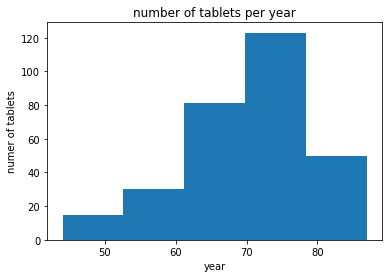

In [13]:
reigns = {'Ur-Namma' : 0, 
              'Šulgi' : 18, 
              'Amar-Suen': 66, 
              'Šū-Suen' : 75, 
              'Ibbi-Suen' : 84}
normdates = []
for key in cat.keys():
    date = cat[key]['date_of_origin'].split('.')
    king = date[0]
    year = date[1]
    year = year[:2].strip()
    offset = reigns.get(king, 999)
    if year.isnumeric():
        normdate = int(year) + offset
        normdates.append(normdate)
    else:
        normdate = 999
    cat[key]['normdate'] = normdate
md = int(statistics.median(normdates))  # median of all known years
for key in cat.keys():
    if cat[key]['normdate'] >= 999:
        cat[key]['normdate'] = md
x = [cat[key]['normdate'] for key in cat.keys()]
plt.hist([x], bins=5)
plt.xlabel("year")
plt.ylabel("numer of tablets")
plt.title("number of tablets per year")
plt.show();

# DataFrame

The `parsejson()` function has filled the list of lists `lemm_l` with data. This list  is read into a DataFrame for further manipulation. We remove commas and spaces from Guide Words and simplify the field `id_text` to read "P433582" instead of "epsd2/admin/ur3/P433582" (all documents derive from [epsd2/admin/ur3](http://oracc.org/epsd2/admin/ur3)).

Finally the code adds a field `id_line` (integer) in order to keep track of the lines in a document. Since lines are meaningful units in Sumerian administrative texts, this will be an important tool. 

All of these steps are identical (or very similar) to steps explained in Chapter 2.1.

In [14]:
words = pd.DataFrame(lemm_l).fillna('')
keep = ['extent', 'scope', 'state', 'id_word', 'id_text', 'form', 'cf', 'gw', 'pos', 'ftype', 'label']
words = words[keep]
words['gw'] = words['gw'].replace([' ', ','], ['-', ''], regex=True)
words['id_text'] = [i[-7:] for i in words['id_text']]
words['id_line'] = [int(i.split('.')[1]) for i in words['id_word']]

## Creating a Lemma Field

The `lemma` field strings Citation Form, Guide Word, and Part of Speech together and is dealt with in the same way as in Chapter 2.1 Words that remain unlemmatized (e.g. because of illegible or broken signs) are represented by their `form` (transliteration) and numbers receive the POS 'NU'. 

In the DataFrame (physical) breaks and text divisions (marked by horizontal rulings on the tablet, blank lines, and the like) are preserved in the field `state`. Such demarcations have their own row in the DataFrame and receive their own line ID, but they do not have data in fields such as `form`. In order to keep track of breaks we will define two different types: logical and physical breaks. The keywords break_physical and break_logical are included in the `lemma` column. 

In [15]:
physical_break = ['illegible', 'traces', 'missing', 'effaced']
logical_break = ['other', 'blank', 'ruling']
words['lemma'] = words["cf"] + '[' + words["gw"] + ']' + words["pos"]
words.loc[words["cf"] == "" , 'lemma'] = words['form'] + '[NA]NA'
words.loc[words["pos"] == "n" , 'lemma'] = words['form'] + '[]NU'
words.loc[words["state"].isin(logical_break), 'lemma'] = "break_logical"
words.loc[words["state"].isin(physical_break), 'lemma'] = "break_physical"
words.head(10)

,extent,scope,state,id_word,id_text,form,cf,gw,pos,ftype,label,id_line,lemma
0,,,,P512773.3.1,P512773,3(diš),,,n,,o 1,3,3(diš)[]NU
1,,,,P512773.3.2,P512773,{geš}pisan,bisaŋ,basket,N,,o 1,3,bisaŋ[basket]N
2,,,,P512773.3.3,P512773,a₂-an,aʾan,handle,N,,o 1,3,aʾan[handle]N
3,,,,P512773.3.4,P512773,uruda,urud,copper,N,,o 1,3,urud[copper]N
4,,,,P512773.3.5,P512773,la₂-a,la,hang,V/t,,o 1,3,la[hang]V/t
5,,,,P512773.4.1,P512773,n,,,n,,o 2,4,n[]NU
6,,,,P512773.4.2,P512773,ku₃-babbar,kugbabbar,silver,N,,o 2,4,kugbabbar[silver]N
7,,,,P512773.4.3,P512773,{na₄}za-gin₃,zagin,lapis,N,,o 2,4,zagin[lapis]N
8,,,,P512773.4.4,P512773,{d}en-lil₂,Enlil,1,DN,,o 2,4,Enlil[1]DN
9,,,,P512773.4.5,P512773,{d}nin-lil₂-la₂,Ninlil,1,DN,,o 2,4,Ninlil[1]DN


# Nodes and Roles
In this section instances Proper Nouns (Personal Names, Royal Names, and Divine Names) are identified and each name instance is assigned a role in a transaction (for instance 'deliverer'). In a next step, two name instances are connected by an edge, where one name instance functions as the source, the other as the target. This way a directed network is created.

## Document Typology

Different types of documents will be treated differently. In the Treasure Archive the main document types are Intake, Expenditure, and Transfer.

|  type           | keyword         | lemma(s)              | description |
|----------------|------------------|-----------------------|-------------|
| Intake      | mu-kuₓ(DU)      | mu.DU\[delivery\]N      | materials delivered to the administration |
| Expenditure | ba-zi or zi-ga  | zig[rise]V/i          | materials expended by the administration |
| Transfer    | šu ba-ti        | šu\[hand\]N teŋ\[near\]V/i | materials transfered from one office to another |

In the great majority of cases they can be identified simply by looking  for the keyword lemmas.

This typology is discussed in much detail in Paoletti's *Der König und sein Kreis* (2012), Chapters 2.1 and 3.1.

In [16]:
texttype = []
for i in ids:
    ttype = ''
    text = list(words.loc[words.id_text == i, 'lemma'])
    if 'mu.DU[delivery]N' in text:
        ttype = 'intake'
    elif 'zig[rise]V/i' in text:
        ttype = 'expenditure'
    elif 'teŋ[near]V/i' in text: 
        ttype = 'transfer'
    texttype.append(ttype)
treasure = dict(zip(ids, texttype))

## Harvest Nodes

For the node list, select Personal Names (PN) and Royal Names (RN) but skip those that appear in Year Names or Seals. Add lugal (king), sukkalmah (prime minister), and nin (queen), because these actors may be mentioned without personal name. Seals and year names are excluded here because the text of a seal or a year name does not directly reflect the transaction that is recorded in the tablet. Seals do include important information about the identity of the sealer (a father's name, a profession and/or loyalty to a king or another high official). Such information could be harvested for node attributes (but that is not done here). Year names include essential chronological information (that is taken care of elsewhere) - but the proper nouns in year names (the name of the king, or the name of a priestess being elected) are not part of the transaction proper.

The resulting DataFrame (called `PNs`) is a subset of the DataFrame `words` (which has all the words in all the texts of the archive).

In [17]:
unnamed = {'lugal[king]N', 'nin[queen]N', 'sukkalmah[official]N'}
names = set(words.loc[words.pos.isin(['PN', 'RN', 'DN']), 'lemma'])
actors = unnamed | names
seal = list(words.loc[words.label.str.contains('seal'), 'id_word'])
yn = list(words.loc[words.ftype == 'yn', 'id_word'])
exclude = seal + yn
PNs = words.loc[(words.lemma.isin(actors)) & (~words.id_word.isin(exclude))].copy()

## Define keywords and the corresponding roles
The accounts use key words to indicate the particular role of each person in a document. Some of these key words (or key phrases, in some instances) follow the Proper Noun, others precede it. Thus when the word **ŋiri\[foot\]N** immediately precedes a Personal Name, that person is an intermediary (or conveyor). A Personal Name followed by **šu\[hand\]N teŋ\[near\]V/i** marks the recipient of goods.

The keywords are associated with a role in two separate dictionaries.

In [18]:
key_post = {'mu.DU[delivery]N': 'deliverer', 'maškim[administrator]N' : 'representative', 
               'zig[rise]V/i' : 'expender',
               'šu[hand]N teŋ[near]V/i': 'recipient' , 'šu[hand]N us[follow]V/t': 'sender', 
           'la[hang]V/t' : 'weigher'
            }
key_pre =  {'ŋiri[foot]N' : 'conveyor', 
            'arua[offering]N' : 'offerer', 'kišib[seal]N' : 'sealer', 
            'gabari[copy]N kišib[seal]N' : 'sealer', 'mu.DU[delivery]N' : 'deliverer',
            'mu[name]N' : 'reason', 'ki[place]N' : 'source', 'kiŋ[work]N ak[do]V/t' : 'producer', 
            'niŋgur[property]N' :'owner', 'šag[heart]N la[hang]V/t' : 'weigher'}

## Determine the Role of each PN
The role of a personal name in an administrative texts is determined by keywords before of after the name. The keywords and their corresponding roles are defined in the dictionaries `key_post` and `key_pre` in the preceding cell.

The DataFrame `PNs`, created above, is an extract from the DataFrame `words` and therefore uses the same indexes. If the index of a Personal Name in `PNs` is `i`, then the word before that name is `words.loc[i-1]`.

We iterate over the index numbers in `PNs` to determine which keywords are found before or after. Before doing so we determine the extent of a document by finding the lowest and highest index number with the same `id_text` as the name instance we are dealing with. Similarly, we can define the extent of the line in which the name is found by finding the lowest and highest index number of the words within the document that share the same `id_line`. With these index numbers we can easily see whether a name is in first position in a line (its index equals the lowest index of that line) or what the last word is in the line in which the name instance appears. We can also check to make sure that when we inspect the next line, this line still belongs to the same document. Working with indexes this way is very fast and flexible - we do not have to look up the P number (in `id_text`) every time, or check the `id_line` field.

Because of the structure of Sumerian grammar, keywords that come *after* the name may be separated from their name instance by one or more positions, as in:
> 	ARAD₂-{d}nanna sukkal-mah maškim			AradNanna the prime minister was representative. 

In this example, maškim (representative) is the keyword, sukkal-mah (prime minister) is an attribute of the name.

In practice the keyword is always the last word on the line, or the first on the next line, as in:
> 	lu₂-{d}nanna šagina nag-su{ki}-ke₄ 		LuNanna the military leader of Nagsu
> 	šu ba-ti 								received

Therefore, if the PN is the first word on the line, we can check  to see if the last word on the line is a keyword and, if so, assign a role to the PN, using the  `key_post` dictionary. We can also look at the first word (or two words) of the next line, to see if there is a keyword in that position. Any word following the PN that is not a keyword is considered an attribute (a father's name, a profession, etc.).

If the PN is not the first word on the line (its index number is higher than the lowest index number of that line), one possibility is that it is preceded by a keyword, as in:
> 	ki lu₂-dingir-ra-ta					from Ludingira

If there is a preceding keyword, we use the `key_pre` dictionary to assign a role. But a PN later in the line may also be the name of a parent (PN1 dumu PN2) or some other relative, or, occasionally, the name of an employer, as in:
> 	giri₃ a-bu-du₁₀ lu₂ a-bu-ni-ka		Conveyor: Abuṭāb the man of Abuni

In the case of Abuni, his name is not preceded by a keyword, but there is another PN earlier in the line. Abuni does not have a role in the document directly, but he is involved indirectly by his relation of authority to Abuṭāb. In such cases the role is defined as 'relation'. 

If none of these methods results in a role assignment, we fall back to default roles. Default roles are different for different document types. Transfer texts (keywords šu ba-ti) and Intake (mu.DU\[delivery\]N) may record deliveries by multiple people who are not specifically marked with a keyword. The default in those texts is "source". Expenditure texts (zi-ga or ba-zi) may record expenditures to various people, not marked specifically. Here the default is "recipient".

The code takes care of a few special cases. If a name is preceded by u\[and\]CNJ the role of that name is the same as the role of the preceding name. The (infrequent) expression ki PN-še₃ ("to the place of PN") uses the same keyword ki\[place\]N as the very common expression ki PN-ta ("from the place of PN") but has the opposite meaning. Since the morphology (-ta vs. -še₃) is not available in the `lemma` column, we have to use the `form` column to check for such instances. The expression kin ak, which precedes the name of a craftsman (finished work of PN) may be found on the line preceding the name.

Breaks in the text and horizontal rulings have their own entries in the DataFrame `words`, with separate index numbers and a separate `id_line`. This means that while looking for keywords in a preceding or following line the code will never "jump" over such a break. If, for instance, a document has a name instance right before a break and the line right after the break has šu ba-ti, this will not result in the role "recipient" for the name instance because the break is the next line. It is possible that a name instance right before or right after a break does not receive a role because key words are missing - and is then assigned a default role. This is a possible source of errors.

Much of the code here might be used in the same way for other Ur III archives, but it is likely that there will be other keywords and other special cases that one would need to consider.

In [19]:
def get_attributes(PN_index, last_word_in_line):
    """This function takes all the words following a PN on the same line and 
    designates those as attributes of the PN. If there are key words among 
    the words follwoing the PN, those are removed from the attributes. The arguments
    are the index number of the PN and the index number of the last word
    in the line in which the PN appears."""
    attr = ''
    if i < last_word_in_line:  # PN is not the last word of the line
        attr = list(words.loc[i+1:last_word_in_line]['lemma'])   # all words following a PN in the same line are attributes
        attr = [w for w in attr if not w in key_post]  # except for keywords
        if len(attr) > 1: 
            if ' '.join(attr[-2:]) in key_post: # multi-word keywords are removed
                attr = attr[:-2]
    return attr

In [20]:
def check_keywords_after(i, role):
    """This function checks to see if the last word on the line in which the PN is found
    is one of the key words in the dictionary key_post. If so, the dictionary is used to 
    assign a role to the PN. The key word may also appear as the first word on the next 
    line. Phrasal key words (consisting of two words) are checked as well. The function takes
    two arguments: the index number of the PN and the role of the PN (in most cases this role
    will equal the empty string). The function returns the role.
    """
    role = key_post.get(words.loc[last_word_in_line]['lemma'], role)    # keyword appears in same line in last position
    role = key_post.get(words.loc[last_word_in_line+1]['lemma'], role) # or in the next line in first position
    if last_word_in_line - first_word_in_line > 1: # the line has more than two words
        lastwords = ' '.join(list(line[-2:]['lemma'])) # two-word keywords (as in šu ba-ti)
        role = key_post.get(lastwords, role)
    if len(nextline) > 1:               # two-word keyword appearing in first position in next line
        firstwords = ' '.join(list(nextline[:2]['lemma']))
        role = key_post.get(firstwords, role) 
    if i > first_word_in_text + 1 and role == '':  # at least two words preceded the PN in the text
                                    # special case: if kin ak or ša₃ i₃-la₂ is found on preceding line 
        preceding2words = ' '.join(list(words.loc[i-2:i-1]['lemma']))
        role = key_pre.get(preceding2words, role)
    return role

In [21]:
def check_keywords_before(i, role):
    """This function checks to see if the word preceding the PN is a key word in the dictionary key_pre.
    If so, the dictionary is used to assign a role to the PN. The function considers various
    special cases, such as two names connected by 'and' or two names in a (family) relationship. The function takes
    two arguments: the index number of the PN and the role of the PN (which may well be the empty 
    string). The function returns the role."""
    firstwords = ' '.join(list(line.loc[first_word_in_line:i-1]['lemma']))  # join all words before PN
    role = key_pre.get(firstwords, role)        # ŋiri₃ PN; ki PN-ta; kin ak PN; etc
    if line.loc[first_word_in_line]['lemma'] == 'ki[place]N' and line.loc[last_word_in_line]['form'].endswith('-še₃'): 
        role = 'destination'              # special case: ki PN-še₃         
    if role == '':                # role has not been filled yet
        PN = [w for w in line.loc[first_word_in_line:i-2]['lemma'] if w in list(PNs['lemma'])] # is there another PN previously in the line?
        if PN:                                                                  
            if words.loc[i-1]['lemma'] == 'u[and]CNJ':   # PN1 u PN2
                if roles:
                    role = roles[-1]               # same role as previous PN
            else:
                role = 'relation'             # as in PN1 dumu PN2
        elif treasure.get(Pno) == 'expenditure': # commodities + PN: recipient
            role = 'recipient'
        else:                              # if there is no preceding PN: drop the name
            role = 'none'                     # this may  need refinement
        if PNs.loc[i]['lemma'] in unnamed and words.loc[i-1]['lemma'] in list(PNs['lemma']):  
            role = 'none'       # 'unnamed' person (e.g. sukkalmah) is preceded by name
    return role

In [22]:
roles = []
attribute = []
for i in PNs.index:                           # the index of PNs is identical to the one of words
# create variables that that contain indexes for the first and last word in the line in which the PN appears, 
# the first and last word in the text, etc. These indexes are used to find key words before or after the PN
# Identify the P number (text ID) of the text in which the word appears, as well as the line ID.
# These variables are used in the functions get_attributes(), check_keywords_after(), and check_keywords_before().
    Pno = PNs.loc[i]['id_text']                    # the text ID (P number)
    lineno = PNs.loc[i]['id_line']                 # the line number in which the name instance appears
    text = words.loc[words.id_text == Pno]         # data frame of the entire text
    line = text.loc[text.id_line == lineno] #  data frame of the line with the PN
    first_word_in_line = min(line.index)                 # index no. of first word in line
    last_word_in_line = max(line.index)                   # index no. of last word in line
    first_word_in_text = min(text.index)                    # index no. of first word in text
    #last_word_in_text = max(text.index)                    # index no. of last word in text
    last_line_in_text = text.loc[max(text.index)]['id_line']          # highest line number in text
    if lineno < last_line_in_text:                       # check that next line is still in the same text
        next_line_id = text.loc[last_word_in_line + 1, 'id_line']  # line id of the word after 
                                           # the last word of the line
        nextline = text.loc[text.id_line == next_line_id]  # data frame of the words in nextline
    else:
        nextline = pd.DataFrame(columns = words.columns) # fake nextline: empty data frame

# first get attributes
    attr = get_attributes(i, last_word_in_line)

# now assign roles. Two different scenarios: either the PN is the first word
# of the line (most likely, keywords will follow), or it is not (most likely, keywords precede).
    role = ''
    if first_word_in_line == i:               # PN in first position
        role = check_keywords_after(i, role)
                
    elif first_word_in_line < i:             # PN appears further in the line with keyword(s) preceding
        role = check_keywords_before(i, role)
        
    if role == '':                                         # role still empty
        if treasure.get(Pno) == 'expenditure': # default role for zi-ga/ba-zi texts
            role = 'recipient'
        elif treasure.get(Pno) in ['intake', 'transfer']:    # default role for mu-DU and šu ba-ti texts
            role = 'source'
    roles.append(role)
    attribute.append(' '.join(attr))
PNs['role'] = roles
PNs['attribute'] = attribute

## Show results in a table with links for checking
The code in the following two cells does not add or change anything, but allows to check the results. One may inspect the entire output, or restrict it to a certain type of role, or one particular text.

The Pandas `style` method creates links out of properly formated HTML anchor (\<a\>) tags. The links are made by adding the `id_word` field to the URL for the treasury database. This will highlight the word in question. Note that `id_word` is fairly stable, but not absolutely so. If the text has been edited in such a way that there are more (or less) lines on the object or there are more (or less) words in the line, the highlighting may be off.

Move the slide to see more (or less) results.

In [23]:
anchor = '<a href="http://oracc.museum.upenn.edu/epsd2/admin/ur3/{}", target="_blank">{}</a>'
PNs2 = PNs[['id_word', 'form', 'pos', 'lemma', 'role', 'attribute', 'id_text']].copy()
PNs2['id_word'] = [anchor.format(val,val) for val in PNs['id_word']]
roles = PNs.role.unique()
roles.sort()
PNcols = ['id_word', 'form', 'pos', 'lemma', 'role', 'attribute']

In [24]:
@interact(rows = (1, len(PNs2), 1), textid = [''] + ids,role=roles)
def showpns(rows = 25, textid = '', role=''):
    if textid == '' and role == '': 
        return PNs2[:rows][PNcols].style
    elif textid == '': 
        return PNs2.loc[PNs2.role == role][:rows][PNcols].style
    elif role == '': 
        return PNs2.loc[PNs2.id_text == textid][:rows][PNcols].style
    else: 
        return PNs2.loc[(PNs2.role == role) & (PNs2.id_text == textid)][:rows][PNcols].style

interactive(children=(IntSlider(value=25, description='rows', max=1104, min=1), Dropdown(description='textid',…

## Special Case: replace `lugal`(king) by the king's name
The king is never referred to by name, but alwas as *lugal* (king). Use the field `date_of_origin` to determine the identity of *lugal* and replace the lemma *lugal\[king\]N* by the appropriate Royal Name (in ORACC style).

In [25]:
kings_oracc = {'Ur-Namma' : 'Urnamma[1]RN', 
              'Šulgi'     : 'Šulgir[1]RN', 
              'Amar-Suen' : 'Amarsuenak[1]RN', 
              'Šū-Suen'   : 'Šusuen[1]RN', 
              'Ibbi-Suen' : 'Ibbisuen[1]RN'}


In [26]:
PNs["date"] = [cat[P_no]["date_of_origin"] for P_no in PNs.id_text]
PNs["king"] = [cat[P_no]["date_of_origin"].split('.')[0] for P_no in PNs.id_text]
PNs["king"] = [kings_oracc.get(king, 'lugal[king]N') for king in PNs.king]
PNs.loc[PNs.lemma == 'lugal[king]N', "lemma"] = PNs.king

## Merge Names
The following names/titles, all refer to the same person: AradNannak\[0\]PN, Aradnanna\[0\]PN, Aradŋu\[0\]PN, and sukkalmah\[official\]N

In [27]:
Aradnannak = ['Aradnanna[0]PN', 'Aradŋu[0]PN', 'sukkalmah[official]N']
PNs.loc[PNs.lemma.isin(Aradnannak), 'lemma'] = 'AradNannak[0]PN'

# Create Edges
In order to create edges we need to decide what the direction is of the movement. For instance, goods go from a 'source' to a 'conveyor' and from there to a 'recipient'. This example creates two edges: 
> source => conveyor </br>
> conveyor => recipient

Each edge is a separate row in a new dataframe, whith four columns: `source`, `target`, `id_text`, and `edgetype`.

In order to create an edge we find a name, check its role, and then look for a name with an appropriate role further on in the text. In an Intake document, if we find an `conveyor` (keyword ŋiri₃) we want to find a matching `recipient` (šu ba-ti) - this will be the first PN with role `recipient` after our `conveyor`. If we find a `recipient` we want to find a matching `expender` later in the text. In an Intake document we will not find one, because the `recipient`is found at the end with the keywords šu ba-ti (that edge has already been made when the `source` or the `conveyor` was encountered earlier in the text). In Expenditure documents, however, a list of recipients comes first, each one potentially followed by a `representative` or `conveyor` with an `expender` at the end. By  searching only forwards we avoid making double edges.

This way we can take care of multiple transaction texts, where we may have multiple pairs of "source" and "conveyor" (or "representative") and one "recipient" at the end, or multiple "recipients" followed by one "expender".

The one exception is for the role "relation" in a line like: 
> 	giri₃ a-bu-du₁₀ lu₂ a-bu-ni-ka		Transporter: Abuṭāb the man of Abuni

Here, Abuni has the role 'relation', which always points backwards in the document. The "relation" (here: Abuni) is the Source, and the first name encountered before this one is the Target (here Abuṭāb), whatever its role. Since, in this case, Abuṭāb has the role "conveyor" he will have three edges ([Trouvaille 86](http://oracc.org/epsd2/admin/ur3/P134759)):

> Abuni  => Abuṭāb </br>
> Šu-Enlil => Abuṭāb </br>
> Abuṭāb => PuzurErra
 
Šu-Enlil, who sends his goods through Abuṭāb to PuzurErra, is qualified himself as "son"of the king", so that he, in turn, will appear in  another edge in which the king is Source, and Šu-Enlil Target.
 
These edges are of different kinds. By default all edges are of the type "transaction", except for those that express a relationship (familial or otherwise); those are marked as "relation".

In [28]:
edges = []
for Pno in ids:                              # one document ID at a time
    people = PNs.index[PNs.id_text == Pno]    # indexes of all the people in that document
    for p in people:                       # iterate over those indexes
        rest = PNs.loc[p+1 : max(people)].index # indexes of all other name instances, later in the document
        source = ''
        target = ''
        edgetype = 'transaction'   # that is the default
        role = PNs.loc[p]['role']
        if role in ['conveyor', 'representative']:
            if treasure.get(Pno) == 'expenditure':
                target = PNs.loc[p]['lemma']
                q = [n for n in rest if PNs.loc[n]['role'] in ['source', 'expender']]  # look for source after the target
                if q:
                    source = PNs.loc[q[0]]['lemma'] 
            else:
                source = PNs.loc[p]['lemma']
                q = [n for n in rest if PNs.loc[n]['role'] in ['recipient', 'sealer']]  # look for target after the source
                if q:
                    target = PNs.loc[q[0]]['lemma']  
        elif role in ['sender', 'deliverer', 'source', 'producer', 'weigher', 'owner']:
            source = PNs.loc[p]['lemma']
            q = [n for n in rest if PNs.loc[n]['role'] in ['recipient', 'sealer', 'conveyor']] 
            if q:
                target = PNs.loc[q[0]]['lemma']
        elif role == 'relation':
            source = PNs.loc[p]['lemma']
            q = [n for n in people if n < p]
            if q:
                target = PNs.loc[q[-1]]['lemma']
                edgetype = 'relation'
        elif role in ['recipient', 'sealer']:
            target = PNs.loc[p]['lemma']
            q = [n for n in rest if PNs.loc[n]['role'] in ['representative', 'source', 'conveyor', 'expender']]
            if q:
                source = PNs.loc[q[0]]['lemma']
        elif role in ['reason']:
            target = PNs.loc[p]['lemma']
            q = [n for n in rest if PNs.loc[n]['role'] in ['recipient']]
            if q:
                source = PNs.loc[q[0]]['lemma']
        elif role == "offerer":
            source = PNs.loc[p]['lemma']
            q = [n for n in rest if PNs.loc[n]['role'] in ['source', 'expender']]
            if q: 
                target = PNs.loc[q[0]]['lemma']
        if source and target:
            edges.append([source, target, Pno, edgetype])

## Show results with links for checking
The code in the following two cells does not add or change anything, but allows to check the results. In the second cell one may enter a condition to restrict the output to a particular document, or a particular type of edge for instance

The Pandas `style` method creates links out of properly formated HTML anchor (\<a\>) tags. The links are created by adding the field `id_text` to the URL for the ur3 database.

In [29]:
edgs = pd.DataFrame(edges)
edgs.columns = ['source', 'target', 'id_text', 'edge_type']
anchor = '<a href="http://oracc.museum.upenn.edu/epsd2/admin/ur3/{}", target="_blank">{}</a>'
edgs_style = edgs.copy()
edgs_style['link'] = [anchor.format(val,val) for val in edgs_style['id_text']]
target = sorted(list(edgs_style.target.unique()))
source = sorted(list(edgs_style.source.unique()))
cols = ['link', 'source', 'target', 'edge_type']

In [30]:
@interact(rows = (1, len(edgs_style), 1), source = [''] + source, target = [''] + target, textid = [''] + ids)
def showedges(rows = 25, source = '', target = '', textid = ''):
    if textid == '' and source == '' and target == '': 
        return edgs_style[:rows][cols].style
    elif source == '' and target == '': 
        return edgs_style.loc[edgs_style.id_text == textid][:rows][cols].style
    elif source =='' and textid == '': 
        return edgs_style.loc[edgs_style.target == target][:rows][cols].style
    elif target == '' and textid == '': 
        return edgs_style.loc[edgs_style.source == source][:rows][cols].style
    elif target == '': 
        return edgs_style.loc[(edgs_style.id_text == textid) & (edgs_style.source == source)][:rows][cols].style
    elif source == '': 
        return edgs_style.loc[(edgs_style.id_text == textid) & (edgs_style.target == target)][:rows][cols].style
    elif textid == '': 
        return edgs_style.loc[(edgs_style.target == target) & (edgs_style.source == source)][:rows][cols].style
    else: 
        return edgs_style.loc[(edgs_style.target == target) & (edgs_style.source == source) &edgs.id_text == textid][:rows][cols].style

interactive(children=(IntSlider(value=25, description='rows', max=581, min=1), Dropdown(description='source', …

## Add edges by hand
Complex administrative texts such as UTI 6 3800 ([P141796](http://oracc.org/epsd2/P141796)) and Ist PD 912 ([P332256](http://oracc.org/epsd2/P332256)), or documents that are badly damaged such AUCT 1 276 ([P103121](http://oracc.org/epsd2/P103121)) are not parsed well with the routine above. These edges are collected by hand in the file /edges/add_edges.txt. The routine will note if a node is not currently in the PNs dataframe. If so, this may indicate an error somewhere, or it could simply be a name that had not been recognized so far.

In [31]:
with open('edges/add_edges.txt', 'r', encoding='utf8') as e:
    add_edges = pd.read_csv(e, sep=',')
add_source = list(add_edges.source.unique())
add_target = list(add_edges.target.unique())
add = list(set(add_source + add_target))
for a in add: 
    if not a in PNs.lemma.unique(): 
        print(f"{a} is not recognized")
replace = add_edges.id_text.unique()
edgs = edgs.loc[~edgs.id_text.isin(replace)]
edgs = edgs.append(add_edges)

Nimgirinimgina[0]PN is not recognized


## Drop Duplicate Edges
For various reasons a single document may create duplicate edges. In large summary texts we may encounter the same two people who interact at different points in time and those are true duplicates that should increase the weight of the edge. More common, however, are two other situations. First, illegible or partly legible names may be represented as identical, resulting in multiple transaction between a Mr or Mrs X and a recipient or expender. Second, the same relationship may be expressed multiple times, for instance Me-ištaran dumu-munus lugal (Me-Ištaran the daughter of the king).

For the time being, all duplicate edges are removed.

In [32]:
edgs = edgs.drop_duplicates()

## Merge Edges

Edges that connect the same people, but originate in different documents are merged. The number of merged edges becomes the weight of the edge. The field `id_text` now becomes a list of P numbers.

Edges are merged naively, without checking for the possibility of namesakes. This issue is not a big deal in this particular archive, but will need more attention in larger text groups.

In [33]:
edgs['normdate'] = [cat[i]['normdate'] for i in edgs['id_text']]
edgs_merged = edgs.groupby(['source', 'target', 'edge_type']).agg({'id_text' : list, 'normdate' : list}).reset_index()
edgs_merged['weight'] = [len(i) for i in edgs_merged['id_text']]
edgs_merged['min_date'] = [min(date) for date in edgs_merged['normdate']]
edgs_merged['max_date'] = [max(date) for date in edgs_merged['normdate']]
edgs_merged

,source,target,edge_type,id_text,normdate,weight,min_date,max_date
0,Abisimti[0]PN,Damu[1]DN,transaction,[P144477],[77],1,77,77
1,Abisimti[0]PN,Gemenannak[0]PN,transaction,[P332256],[71],1,71,71
2,Abisimti[0]PN,Gunura[1]DN,transaction,[P144477],[77],1,77,77
3,Abisimti[0]PN,Ninisinak[0]PN,transaction,[P144477],[77],1,77,77
4,Abisimti[0]PN,Nuhilum[0]PN,relation,[P111905],[72],1,72,72
...,...,...,...,...,...,...,...,...
497,ŠuʾEštar[0]PN,Šulgiʾabi[0]PN,transaction,[P127861],[69],1,69,69
498,ŠuʾEštar[0]PN,ŠuʾEštar[0]PN,transaction,[P127861],[69],1,69,69
499,ṢillušDagan[0]PN,Ilabuʾigadu[0]PN,transaction,[P116199],[63],1,63,63
500,ṢillušDagan[0]PN,PuzurErra[0]PN,transaction,[P134759],[63],1,63,63


# Build the Graph

## Create initial Directed Graph
NetworkX may create a network directly from the edgelist that was created in Pandas. The node list is created from the edge list. Node attributes need to be added separately.

In [34]:
G=nx.convert_matrix.from_pandas_edgelist(edgs_merged, source = 'source', target = 'target', 
                                         edge_attr = ['id_text', 'weight', 'edge_type', 'min_date', 'max_date'],
                                        create_using = nx.DiGraph())

In [35]:
nodecolors = {'PN' : '#525252', 'DN' :'#00ffff', 'RN' : '#8469e7'}
degree = {name : G.degree[name] for name in G.nodes}
edge_size = {(a, b) : G[a][b]['weight'] for (a,b) in G.edges}
edge_color = {(source, target): 'blue' if G[source][target]['edge_type'] == 'relation' 
                 else 'green' for source, target in G.edges}
eigenvector = nx.eigenvector_centrality(G)
nx.set_node_attributes(G, degree, "degree")
nx.set_node_attributes(G, eigenvector, "eigenvector_centrality")
nx.set_edge_attributes(G, edge_color, "edge_color")
nx.set_edge_attributes(G, edge_size, "edge_size")

## Display Graph for Single Text or Single Node (Ego)
In order to check the validity of the process above the code below allows the user to display the network for a single text, or to display the ego-network of a single node. When displaying these sub-networks, one may open the edition or editions of the document(s) involved in [ORACC](http://oracc.org) by clicking on a button.

In order to do so we connect a set of widgets with three functions: `display_single_text()`, `display_ego()`, and `open_edition_page()`. 

### display_single_text()

The `display_single_text()` function is called when a dropdown menu is changed. There are two such dropdown menus, one where the user may select a P number (the text ID) and one with publication numbers. Publication numbers and ID numbers may be mapped to one another by two dictionaries (`p2pub` and `pub2p`) so that the two dropdowns change in unison.

The function reads the new value of the dropdown in the variable `id_text` and uses that value to filter the edges in the main graph G, as follows:
```python
s_edges = ((s, t, a) for s,t,a in G.edges(data=True) if id_text in a['id_text'])
```
The expression `G.edges(data=True)` (or `G.edges.data()`) returns a list of tuples, where each tuple has the format `(source, target, edge-attributes)`. The third element of the tuple (the edge attributes) has the form of a dictionary. As a result, `s_edges` is a subset of the edges in G, that only contains the edges that are available in that one single document. Note that the edge attribute "id_text" is a string that may contain more than one P number (because the same source, target combination may be attested in multiple documents). That is why the consition is formed with an `in` expression (`if id_text in a['id_text']`).

This sub-set of edges is than used to crreate a new (directed) graph. To make the graph more informative we define edge colors (blue for relations and red for transactions) and node colors (purple for human beings and cyan for divine beings). The graph is then drawn as a circular graph (`nx.draw_circular()`; many other layout options are available), specifying labels, node colors, etc. Behind the scenes, the actual drawing is done by matplotlib, so we initiate the figure with `plt.figure()`.

The graph of a single text (or any graph in NetworkX) has a number of characteristics that we can call and print as additional information, including the number of nodes, the number of edges, and the density of the graph (which percentage of the potential number of edges is realized?).

In [36]:
def display_single_text(change):
    if change.get("owner") == dropdown: # if the change came from the first dropdown menu
        id_text = dropdown.value
        dropdown2.unobserve(display_single_text, 'value')
        dropdown2.value = p2pub.get(dropdown.value, "None") 
        dropdown2.observe(display_single_text, 'value')
    elif change.get("owner") == dropdown2: # if the change came from the 2nd dropdown menu
        id_text = pub2p.get(dropdown2.value, "None")
        dropdown.unobserve(display_single_text, 'value')
        dropdown.value = id_text
        dropdown.observe(display_single_text, 'value')
    pnos["id_text"] = id_text
    if id_text == 'None':    
        with out:
            clear_output()
        return
    s_edges = [(s, t) for s,t,a in G.edges(data=True) if id_text in a['id_text']]
    graph = G.edge_subgraph(s_edges)
    node_c = [nodecolors.get(name[-2:], '#cc0066') for name in graph.nodes]
    edge_c = nx.get_edge_attributes(graph, 'edge_color').values()
    plt.figure(figsize=(8, 8))
    plt.gca().margins(0.15, 0.15) # provide margins to prevent labels from going over the edge
    nx.draw_circular(graph, with_labels=True,node_size=300, font_size = 12, edge_color=edge_c, 
                node_color=node_c, width=2.0, alpha=0.8, arrows=True);
    with out:
        clear_output()
        print(f"Nodes: {graph.number_of_nodes()}; Density: {nx.density(graph): .4f}")
        print(f"Edges: {graph.number_of_edges()}")
        plt.show();
    return

### display_ego()

This function is called when one of the dropdown menus "Ego" or "radius" is changed. In order to display an Ego network we may use the `ego_graph()` function in NetworkX. The value of Ego (the name of the actor at the center of the Ego network) is read from the dropdown menu (`dropdown3`). The radius defaults to 2, but may get any value between 1 (only direct neighbors) to 10. The P numbers of all the texts that contain this name in an edge are listed in the variable `textids` (a list) and this list is transformed to a single string and assigned to the key "id_text" in the dictionary `p_nos`. This dictionary is used in the function `open_edition_page()` to open one or more texts in [ORACC](http://oracc.org). In the graph, nodes and edges are colored in the same way as in `display_single_text()`. The graph G is a directed graph, but the function `ego_graph()` needs the option `undirected = True`, otherwise only outgoing edges are included in the Ego network. This does not change the network itself into an undirected network.

In [37]:
def display_ego(change):
    Ego = dropdown3.value
    radius = dropdown4.value
    if Ego == 'None':
        with out:
            clear_output()
        return
    graph = nx.ego_graph(G, Ego, radius=radius, undirected=True)  # undirected = False results in an Ego network that
                                                                  # only includes outgoing edges.
    eigenv = eigenvector.get(Ego)
    textids = nx.get_edge_attributes(graph, 'id_text').values()   # id_text is a list, textids is a list of lists
    textids = set(itertools.chain.from_iterable(textids))         # from_iterable pulls all items from a list of lists
    pnos["id_text"] = ','.join(textids)
    node_c = [nodecolors.get(name[-2:], '#cc0066') for name in graph.nodes]
    edge_c = nx.get_edge_attributes(graph, 'edge_color').values()
    plt.figure(figsize=(8, 8))
    plt.gca().margins(0.15, 0.15) # provide margins to prevent labels from going over the edge
    nx.draw_circular(graph, with_labels=True,node_size=300, font_size = 12, edge_color=edge_c, 
                node_color=node_c, width=2.0, alpha=0.8, arrows=True);
    with out:
        clear_output()
        print(f"Nodes: {graph.number_of_nodes()}; Density: {nx.density(graph): .4f}")
        print(f"Edges: {graph.number_of_edges()}; Eigenvector Centrality: {eigenv: .4f}")
        print(f"Documents: {len(textids)}")
        plt.show();
    return

### open_edition_page()
This function is called when one clicks the button "Open Edition in ORACC". The function reads the key `id_text` in the dictionary `pnos`. The key is initialized with the value "None" (a string). When the functions `display_ego()` or `display_single_text()` are called the key will receive a value that either consists of a single P number, or a sequence of P numbers, separated by commas. This value is used in the URL that is the sole argument of `webbrowser.open()`.

In [38]:
def open_edition_page(change):
    if not pnos.get("id_text") == "None":
        url = f"http://oracc.museum.upenn.edu/epsd2/admin/ur3/{pnos['id_text']}"
        webbrowser.open(url)

### Create and Display the Widgets
The code in the following cell creates the widgets (the dropdown menus etc.), links those to the functions created in the previous cell, and displays the results. The dropdown menus for "Publication" and "Ego" use a custom sort order that ignores case and places the special characters (such as š and ṭ) in the correct position.

In [39]:
sortorder = " []'ʾaāâbcdeēêfgŋhiīîjklmnopqrsṣštṭuūûvwxyz0123456789₀₁₂₃₄₅₆₇₈₉ₓ{}[]().-+/~?@×|&'<>,§"
Egos = sorted(list(G.nodes), key=lambda word: [sortorder.index(c.casefold()) for c in word]) # use custom sort order
publications = sorted(list(pub2p.keys()), key=lambda word: [sortorder.index(c.casefold()) for c in word])
button = widgets.Button(description = 'Open Edition in ORACC', layout=Layout(width='180px'))
button.style.button_color = "lightblue"
dropdown = widgets.Dropdown(options = ['None'] + ids, value='None', description = 'Select Pno')
dropdown2 = widgets.Dropdown(options = ['None'] + publications, value = 'None', description = "Publication")
dropdown3 = widgets.Dropdown(options = ['None'] + Egos, value='None', description = 'Ego')
dropdown4 = widgets.Dropdown(options = range(1,10), value=2, description = 'Radius')
pnos = {"id_text" : "None"} # dictionary for storing P numbers; to be filled by the functions attached to the widgets.
out = widgets.Output()
dropdown.observe(display_single_text, 'value')
dropdown2.observe(display_single_text, 'value')
dropdown3.observe(display_ego, 'value')
dropdown4.observe(display_ego, 'value')
button.on_click(open_edition_page)
col1 = widgets.VBox([dropdown, dropdown2, button])
col2 = widgets.VBox([dropdown3, dropdown4])
row = widgets.HBox([col1, col2])
col = widgets.VBox([row, out])
display(col)

## Save the Graph
Save the graph for use in the next notebook.

In [40]:
import pickle
pickle.dump(G, open('pickle/treasury.p', 'wb'))